In [ ]:
# 대충 예제를 따라했지만 작은 오류들이 많다. 하지만 수정은 하지않았기에 처음 실행 시에는 동작하긴한다.

In [1]:
from PyQt5 import QtCore, QtGui, QtWidgets
import ctypes
import cv2
import os
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

import train_dialog

In [2]:
class ML_Class(QtCore.QThread):
    finish_signal = QtCore.pyqtSignal(list)
    process_signal = QtCore.pyqtSignal(int)
    predict_signal = QtCore.pyqtSignal(list)
    
    def __init__(self, train_data, train_label, test_data, test_label, learning_rate, batch_size, epochs, class_count):
        super().__init__()
        self.model = None
        self.train_data = train_data
        self.train_label = train_label
        self.val_data = test_data
        self.val_label = test_label
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.epochs = epochs
        self.class_count = class_count
        
        self.receive = 1
        self.break_learning = 0
        self.learning_history = None
        self.data = None
    
    def stop_learning(self):
        self.break_learning = 1
        
    def receive_data(self, data):
        if self.receive == 0:
            self.receive = 1
            self.data = data
            
    def run(self):
        try:
            self.train_data = np.asarray(self.train_data, dtype = np.float32)
            self.train_label = np.asarray(self.train_label, dtype = np.float32)
            self.val_data = np.asarray(self.val_data, dtype = np.float32)
            self.val_label = np.asarray(self.val_label, dtype = np.float32)
            data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
                            featurewise_center = True,
                            featurewise_std_normalization = True,
                            rotation_range = 20,
                            width_shift_range = 0.2,
                            height_shift_range = 0.2,
                            horizontal_flip = True,
            )
            self.model = tf.keras.Sequential([
                        Conv2D(16, 3, padding = 'same', activation = 'relu', input_shape = (224, 224, 3)),
                        MaxPooling2D(),
                        Dropout(0.2),
                        Conv2D(32, 3, padding = 'same', activation = 'relu'),
                        MaxPooling2D(),
                        Dropout(0.2),
                        Conv2D(64, 3, padding = 'same', activation = 'relu'),
                        MaxPooling2D(),
                        Dropout(0.2),
                        Flatten(),
                        Dense(512, activation = 'relu'),
                        Dense(self.class_count, activation = 'softmax'),
            ])
            optimisation = tf.keras.optimizers.Adam(learning_rate = self.learning_rate)
            
            self.model.compile(optimisation,
                               loss = 'sparse_categorical_crossentropy',
                               metrics = ['accuracy'],
                              )
            data_generator.fit(self.train_data)
            accuracy = []
            val_accuracy = []
            loss = []
            val_loss = []
            batch = len(self.train_data) // self.batch_size
            
            for step in range(self.epochs):
                count = 0
                for x_batch, y_batch in data_generator.flow(self.train_data, self.train_label, batch_size = self.batch_size):

                    if self.break_learning:
                        return
                    self.learning_history = self.model.fit(x_batch, y_batch, validation_data = (self.val_data, self.val_label))
                    accuracy.append(self.learning_history.history['acc'][0])
                    val_accuracy.append(self.learning_history.history['val_acc'][0])
                    loss.append(self.learning_history.history['loss'][0])
                    val_loss.append(self.learning_history.history['val_loss'][0])
                    process = int(100*((step*batch) + (count+1))/ (self.epochs*batch))
                    self.process_signal.emit(process)
                    count += 1
                    if count >= batch:
                        break
            history = []
            history.append(accuracy)
            history.append(val_accuracy)
            history.append(loss)
            history.append(val_loss)
            self.finish_signal.emit(history)
        except BaseException as b:
            print(str(b))
            return
        
        self.receive = 0
        while True:
            if self.break_learning == 1:
                break
            else:
                if self.receive == 1:
                    predict = self.model.predict(self.data)
                    predict = predict.tolist()
                    self.predict_signal.emit(predict)
                    self.receive = 0

In [3]:

class ImageViewer(QtWidgets.QWidget):
    def __init__(self, parent=None):
        super(ImageViewer, self).__init__(parent)
        self.image = QtGui.QImage()
        self.setAttribute(QtCore.Qt.WA_OpaquePaintEvent)

    def paintEvent(self, event):
        painter = QtGui.QPainter(self)
        painter.drawImage(0, 0, self.image)
        self.image = QtGui.QImage()
        
    @QtCore.pyqtSlot(QtGui.QImage)
    def setImage(self, image):
        if image.size() != self.size():
            self.setFixedSize(image.size())
        self.image = image
        self.update()
        
class UI_Mainwindow(QtWidgets.QMainWindow):
    
    VideoSignal1 = QtCore.pyqtSignal(QtGui.QImage)
    VideoSignal2 = QtCore.pyqtSignal(QtGui.QImage)
    
    def __init__(self):
        super().__init__()
        self.table_column = 6
        self.cam = None
        self.class_image = []
        self.current_class = 1
        self.image_data = []
        self.class_name = []
        self.class_explain = []
        self.capture = 0
        self.table_row = 0
        self.while_count = 0
        self.clicked_cell_position = []
        
        self.learning = 0
        self.predicting = 0
        
        self.setupUI()
        self.show()
        self.set_cam()
        
    def setupUI(self):
        screen_height = ctypes.windll.user32.GetSystemMetrics(1)
        self.program_height = screen_height*0.8
        self.program_width = self.program_height * 1.2
        self.total_width = self.program_width*1.4
        self.setFixedSize(self.total_width, self.program_height)
        self.centralWidget = QtWidgets.QWidget(self)
        self.frame = QtWidgets.QFrame(self.centralWidget)
        self.setGeometry(QtCore.QRect(self.program_width*0.02, self.program_height*0.1, self.program_width*0.36, self.program_width*0.36))
        self.cam_viewer1 = ImageViewer(self.frame)
        self.cam_viewer1.setGeometry(QtCore.QRect(self.program_width*0.02, self.program_width*0.01, self.program_width*0.34, self.program_width*0.34))
        
        font = QtGui.QFont()
        font.setFamily("휴먼엑스포")
        font.setPointSize(int(self.program_height/50))
        
        self.pre_class_button = QtWidgets.QPushButton(self.centralWidget)
        self.pre_class_button.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.03, self.program_width*0.05, self.program_height*0.06))
        self.pre_class_button.setFont(font)
        
        self.next_class_button = QtWidgets.QPushButton(self.centralWidget)
        self.next_class_button.setGeometry(QtCore.QRect(self.program_width*0.93, self.program_height*0.03, self.program_width*0.05, self.program_height*0.06))
        self.next_class_button.setFont(font)
        
        self.current_class_label = QtWidgets.QLabel(self.centralWidget)
        self.current_class_label.setGeometry(QtCore.QRect(self.program_width*0.48, self.program_height*0.03, self.program_width*0.44, self.program_height*0.06))
        self.current_class_label.setFont(font)
        self.current_class_label.setAlignment(QtCore.Qt.AlignCenter)
        self.current_class_label.setStyleSheet("border-style:solid;\n"
                                               "border-color:black;\n"
                                               "border-width:3px;\n" )
        self.class_name_label = QtWidgets.QLabel(self.centralWidget)
        self.class_name_label.setGeometry(QtCore.QRect(self.program_width*0.02, self.program_width*0.36+self.program_height*0.11, self.program_width*0.36, self.program_width*0.05))
        self.class_name_label.setFont(font)
        self.class_name_label.setAlignment(QtCore.Qt.AlignCenter)
        
        self.class_name_edit = QtWidgets.QLineEdit(self.centralWidget)
        self.class_name_edit.setGeometry(QtCore.QRect(self.program_width*0.02, self.program_width*0.36+self.program_height*0.17, self.program_width*0.36, self.program_width*0.05))
        self.class_name_edit.setFont(font)
        self.class_name_edit.setAlignment(QtCore.Qt.AlignCenter)
        
        self.class_explain_label = QtWidgets.QLabel(self.centralWidget)
        self.class_explain_label.setGeometry(QtCore.QRect(self.program_width*0.02, self.program_width*0.36+self.program_height*0.23, self.program_width*0.36, self.program_width*0.05))
        self.class_explain_label.setFont(font)
        self.class_explain_label.setAlignment(QtCore.Qt.AlignCenter)
        
        self.class_explain_edit = QtWidgets.QTextEdit(self.centralWidget)
        self.class_explain_edit.setGeometry(QtCore.QRect(self.program_width*0.02, self.program_width*0.36+self.program_height*0.31, self.program_width*0.36, self.program_width*0.2))
        self.class_explain_edit.setFont(font)
        self.class_explain_edit.setAlignment(QtCore.Qt.AlignCenter)
        
        self.table = QtWidgets.QTableWidget(self.centralWidget)
        self.table.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.1, self.program_width*0.56, self.program_height*0.45))
        self.table.setColumnCount(self.table_column)
        self.table.setAutoScroll(True)
        self.table.horizontalHeader().setVisible(False)
        self.table.verticalHeader().setVisible(False)
        self.table.setFixedHeight(self.program_height*0.45)
        self.table.setFixedWidth(self.program_width*0.56)
        for step in range(self.table_column):
            self.table.setColumnWidth(step, self.program_width*0.09)
        
        self.capture_button = QtWidgets.QPushButton(self.centralWidget)
        self.capture_button.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.58, self.program_width*0.56, self.program_height*0.07))
        self.capture_button.setFont(font)
        
        self.open_image_button = QtWidgets.QPushButton(self.centralWidget)
        self.open_image_button.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.68, self.program_width*0.26, self.program_height*0.05))
        self.open_image_button.setFont(font)
        
        self.delete_image_button = QtWidgets.QPushButton(self.centralWidget)
        self.delete_image_button.setGeometry(QtCore.QRect(self.program_width*0.72, self.program_height*0.68, self.program_width*0.26, self.program_height*0.05))
        self.delete_image_button.setFont(font)
        
        self.delete_class_button = QtWidgets.QPushButton(self.centralWidget)
        self.delete_class_button.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.76, self.program_width*0.26, self.program_height*0.05))
        self.delete_class_button.setFont(font)
        
        self.learning_button = QtWidgets.QPushButton(self.centralWidget)
        self.learning_button.setGeometry(QtCore.QRect(self.program_width*0.72, self.program_height*0.76, self.program_width*0.26, self.program_height*0.05))
        self.learning_button.setFont(font)
        
        self.alam_name_label = QtWidgets.QLabel(self.centralWidget)
        self.alam_name_label.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.84, self.program_width*0.56, self.program_height*0.04))
        self.alam_name_label.setFont(font)
        self.alam_name_label.setAlignment(QtCore.Qt.AlignCenter)
        
        font = QtGui.QFont()
        font.setFamily("휴먼엑스포")
        font.setPointSize(int(self.program_height/70))
        
        self.alam_label = QtWidgets.QLabel(self.centralWidget)
        self.alam_label.setGeometry(QtCore.QRect(self.program_width*0.42, self.program_height*0.89, self.program_width*0.56, self.program_height*0.1))
        self.alam_label.setFont(font)
        self.alam_label.setAlignment(QtCore.Qt.AlignCenter)
        self.alam_label.setStyleSheet("border-style:solid;\n"
                                      "border-color:black;\n"
                                      "border-width:3px;\n" )
        font = QtGui.QFont()
        font.setFamily("휴먼엑스포")
        font.setPointSize(int(self.program_height/50))
        
        self.frame_2 = QtWidgets.QFrame(self.centralWidget)
        self.frame_2.setGeometry(QtCore.QRect(self.program_width*1.02, self.program_height*0.02, self.program_width*0.36, self.program_height*0.97))
        
        self.frame_3 = QtWidgets.QFrame(self.frame_2)
        self.frame_3.setGeometry(QtCore.QRect(self.program_width*0.02, 0, self.program_width*0.32, self.program_height*0.384))
        
        self.cam_viewer2 = ImageViewer(self.frame_3)
        self.cam_viewer2.setGeometry(QtCore.QRect(self.program_width*0.01, self.program_width*0.01, self.program_width*0.3, self.program_width*0.3))
        
        self.predict_name_edit = QtWidgets.QLineEdit(self.frame_2)
        self.predict_name_edit.setGeometry(QtCore.QRect(0, self.program_height*0.4, self.program_width*0.36, self.program_height*0.05))
        self.predict_name_edit.setFont(font)
        self.predict_name_edit.setAlignment(QtCore.Qt.AlignCenter)
        self.predict_name_edit.setReadOnly(True)
        
        self.predict_explain_edit = QtWidgets.QLineEdit(self.frame_2)
        self.predict_explain_edit.setGeometry(QtCore.QRect(0, self.program_height*0.47, self.program_width*0.36, self.program_height*0.08))
        self.predict_explain_edit.setFont(font)
        self.predict_explain_edit.setAlignment(QtCore.Qt.AlignCenter)
        self.predict_explain_edit.setReadOnly(True)
        
        self.frame_4 = QtWidgets.QFrame(self.frame_2)
        self.frame_4.setGeometry(QtCore.QRect(0, self.program_height*0.57, self.program_width*0.36, self.program_height*0.32))     
        
        
        
        font = QtGui.QFont()
        font.setFamily("휴먼엑스포")
        font.setPointSize(int(self.program_height/75))
    
        limit_class_size = 8
        self.predict_class = []
        self.predict_bar = []
        QRect_y = 0
        for i in range(limit_class_size):
            self.predict_class.append(QtWidgets.QLabel(self.frame_4))
            self.predict_class[i].setGeometry(QtCore.QRect(0, self.program_height*QRect_y, self.program_width*0.095, self.program_height*0.038))
            self.predict_class[i].setFont(font)
            
            self.predict_bar.append(QtWidgets.QProgressBar(self.frame_4))
            self.predict_bar[i].setGeometry(QtCore.QRect(self.program_width*0.095, self.program_height*QRect_y, self.program_width*0.265, self.program_height*0.038))
            QRect_y += 0.038
       
        self.progress_label = QtWidgets.QLabel(self.centralWidget)
        self.progress_label.setGeometry(QtCore.QRect(self.program_width*1.03, self.program_height*0.88, self.program_width*0.34, self.program_height*0.08))
        self.progress_label.setFont(font)
        self.progress_label.setAlignment(QtCore.Qt.AlignCenter)
        
        self.progress_bar = QtWidgets.QProgressBar(self.centralWidget)
        self.progress_bar.setGeometry(QtCore.QRect(self.program_width*1.03, self.program_height*0.93, self.program_width*0.34, self.program_height*0.06))
       
    
        self.pre_class_button.setText("<-") 
        self.next_class_button.setText("->")
        self.current_class_label.setText("CLASS =>")
        self.class_name_label.setText("클래스 이름")
        self.class_explain_label.setText("클래스 설명")
        self.capture_button.setText("사 진 촬 영")
        self.open_image_button.setText("이미지 불러오기")
        self.delete_image_button.setText("이미지 삭제하기")
        self.delete_class_button.setText("클래스 삭제하기")
        self.learning_button.setText("학습하러가기")
        self.alam_name_label.setText("알 림 판")
        for i in range(limit_class_size):
            self.predict_class[i].setText("CLASS "+str(i+1))
        self.progress_label.setText("학습진행상황")
        
        self.capture_button.clicked.connect(self.clicked_capture)
        self.next_class_button.clicked.connect(self.go_next_class)
        self.pre_class_button.clicked.connect(self.go_pre_class)
        self.open_image_button.clicked.connect(self.open_image)
        self.table.cellClicked.connect(self.click_image)
        self.delete_image_button.clicked.connect(self.delete_image)
        self.delete_class_button.clicked.connect(self.delete_class)
        self.learning_button.clicked.connect(self.learning_image)
        
        self.setCentralWidget(self.centralWidget)
        
        self.frame_2.hide()
        self.progress_label.hide()
        self.progress_bar.hide()
        
    def set_cam(self):
        self.alam_label.setText("기다려주세요! 준비중입니다.")
        try:
            self.cam = cv2.VideoCapture(0)
            self.cam.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
            self.cam.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
        except BaseException as b:
            self.alam_label.setText("캠을 찾지 못했습니다.")

        try:
            _,image = self.cam.read()
            self.height, self.width = image.shape[:2]
            self.VideoSignal1.connect(self.cam_viewer1.setImage)
            self.VideoSignal2.connect(self.cam_viewer2.setImage)
            self.alam_label.setText("준비되었습니다.")
            self.show_video()
        except BaseException as b:
            self.alam_label.setText("캠 신호에 문제가 발생했습니다.")
            
    def append_table(self, image_frame, image_num):
        try:
            height, width = image_frame.shape[:2]
            color_image = cv2.cvtColor(image_frame, cv2.COLOR_BGR2RGB)
            qt_image = QtGui.QImage(color_image.data,
                                   width,
                                   height,
                                   color_image.strides[0],
                                   QtGui.QImage.Format_RGB888)
            capture_label = QtWidgets.QLabel()
            qt_image = qt_image.scaled(QtCore.QSize(self.program_width*0.09, self.program_height*0.09))
            pixmap = QtGui.QPixmap(qt_image)
            capture_label.setPixmap(pixmap)
            capture_label.setStyleSheet(
                                        "border-width:5px;\n"
                                        "border-style:solid;\n"
                                        "border-color:white;\n"
                                        )
            if image_num % 6 != 0:
                self.table.setCellWidget(self.table_row-1, image_num%6, capture_label)
            else:
                self.table_row += 1
                self.table.setRowCount(self.table_row)
                self.table.setColumnCount(self.table_column)
                self.table.setRowHeight(self.table_row -1, self.program_height*0.09)
                self.table.setCellWidget(self.table_row -1, 0, capture_label)
            self.table.scrollToBottom()
        except BaseException as b:
            print(b)
        
    def show_video(self):
        while True:
            try:
                ret, frame = self.cam.read()
                if ret:
                    frame = cv2.flip(frame, 1)
                    frame = cv2.resize(frame, dsize=(int(self.width*self.program_width*0.34/self.height), int(self.program_width*0.34)))
                    height, width = frame.shape[:2]
                    start_width = int((width-(self.program_width*0.34))/2)
                    frame = frame[:, start_width:int(start_width+(self.program_width*0.34)), :]
                    color_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                    qt_image1 = QtGui.QImage(color_image.data,
                                            self.program_width*0.34,
                                            self.program_width*0.34,
                                            color_image.strides[0],
                                            QtGui.QImage.Format_RGB888)
                    self.VideoSignal1.emit(qt_image1)
                    
                    if self.predicting == 1:
                        qt_image_2 = qt_image1.scaled(QtCore.QSize(self.program_width * 0.3, self.program_width * 0.3))
                        self.VideoSignal2.emit(qt_image_2)
                        frame = cv2.resize(frame, dsize=(224,224))
                        frame = np.asarray(frame, dtype=np.float32)/127.0 - 1
                        frame = frame.reshape((1, 224, 224, 3))
                        self.model.receive_data(frame)
                        
                    if self.capture == 1:
                        if len(self.class_image) < 200:
                            if self.while_count % 2 ==0:
                                frame = cv2.resize(frame, dsize=(224,224))

                                self.append_table(frame, len(self.class_image))
                                self.class_image.append(frame)
                                self.current_class_label.setText("CLASS_"+str(self.current_class)+" -> "+str(len(self.class_image))+"장")
                            else:
                                pass
                            self.while_count += 1
                        else:
                            self.clicked_capture()
                            self.alam_label.setText("한 클래스당 이미지는 최대 200장입니다.")
                    
                    loop = QtCore.QEventLoop()
                    QtCore.QTimer.singleShot(10, loop.quit)
                    loop.exec_()  
            except BaseException as b:
                print(str(b))
                continue
                
    def go_next_class(self):
        if self.check_capture():
            return
        if len(self.image_data) > self.current_class:
            self.image_data[self.current_class-1] = self.class_image
            if self.class_name_edit.text() == "":
                self.class_name[self.current_class-1] = "CLASS_"+str(self.current_class)
            else:
                self.class_name[self.current_class-1] = self.class_name_edit.text()
            self.class_explain[self.current_class-1] = self.class_explain_edit.toPlainText()
            self.init_variable()
            self.class_image = self.image_data[self.current_class]
            for step in range(len(self.class_image)):
                self.append_table(self.class_image[step], step)
            self.current_class += 1
            self.class_name_edit.setText(self.class_name[self.current_class-1])
            self.class_explain_edit.setText(self.class_explain[self.current_class-1])
            self.current_class_label.setText("CLASS_"+str(self.current_class)+" -> "+str(len(self.class_image))+"장")
        else:
            if self.current_class == 8:
                self.alam_label.setText("클래스 수는 최대 8개 입니다.")
                return
            if self.current_class == len(self.image_data)+1 and len(self.class_image) > 0:
                self.image_data.append(self.class_image)
                if self.class_name_edit.text() == "":
                    self.class_name.append("CLASS_"+str(self.current_class))
                else:
                    self.class_name.append(self.class_name_edit.text())
                self.class_explain.append(self.class_explain_edit.toPlainText())
            elif self.current_class == len(self.image_data) and len(self.class_image) > 0:
                self.image_data[self.current_class-1] = self.class_image
                if self.class_name_edit.text() == "":
                    self.class_name[self.current_class-1] = "CLASS_"+str(self.current_class)
                else:
                    self.class_name[self.current_class-1] = self.class_name_edit.text()
                self.class_explain[self.current_class-1] = self.class_explain_edit.toPlainText() 
            else:
                self.alam_label.setText("현재 클래스에 이미지가 있어야 합니다.")
                return
            self.init_variable()
            self.current_class += 1
            self.class_name_edit.setText("CLASS_"+str(self.current_class))
            self.class_explain_edit.setText("")
            self.current_class_label.setText("CLASS_"+str(self.current_class))
        self.class_explain_edit.setAlignment(QtCore.Qt.AlignCenter)
    
    def go_pre_class(self):
        if self.check_capture():
            return
        if self.current_class == 1:
            self.alam_label.setText("첫번째 클래스입니다.")
            return
        if len(self.class_image) > 0:
            if self.current_class == len(self.image_data)+1:
                self.image_data.append(self.class_image)
                if self.class_name_edit.text() == "":
                    self.class_name.append("CLASS_"+str(self.current_class))
                else:
                    self.class_name.append(self.class_name_edit.text())
                self.class_explain.append(self.class_explain_edit.toPlainText())
            else:
                self.image_data[self.current_class-1] = self.class_image
                if self.class_name_edit.text() == "":
                    self.class_name[self.current_class-1] = "CLASS_"+str(self.current_class)
                else:
                    self.class_name[self.current_class-1] = self.class_name_edit.text()
                self.class_explain[self.current_class-1] = self.class_explain_edit.toPlainText()
               
        self.current_class -= 1
        self.init_variable()
        self.class_image = self.image_data[self.current_class-1]
        for step in range(len(self.class_image)):
            self.append_table(self.class_image[step], step)
        self.class_name_edit.setText(self.class_name[self.current_class-1])
        self.class_explain_edit.setText(self.class_explain[self.current_class-1])
        self.current_class_label.setText("CLASS_"+str(self.current_class)+" -> "+str(len(self.class_image))+"장") 
        self.class_explain_edit.setAlignment(QtCore.Qt.AlignCenter)
        
    def open_image(self):
        if self.check_capture():
            return
        if self.check_learning():
            return
        file_dialog = QtWidgets.QFileDialog(self, "이미지 불러오기", "", "ImageFiles(*.jpg, *.png)")
        file_dialog.setOption(QtWidgets.QFileDialog.DontUseNativeDialog, True)
        file_view = file_dialog.findChild(QtWidgets.QListView, "listView")
        
        if file_view:
            file_view.setSelectionMode(QtWidgets.QAbstractItemView.MultiSelection)
            f_tree = file_dialog.findChild(QtWidgets.QTreeView)
            if f_tree:
                f_tree.setSelectionMode(QtWidgets.QAbstractItemView.MultiSelection)
            if file_dialog.exec():
                paths = file_dialog.selectedFiles()
                for step in paths:
                    stream = open(step.encode("UTF-8"), "rb")
                    b = bytearray(stream.read())
                    nparr = np.asarray(b, dtype = np.uint8)
                    img = cv2.imdecode(nparr, cv2.IMREAD_UNCHANGED)
                    if img.shape[-1] != 3:
                        continue
                    else:
                        img = cv2.resize(img, dsize=(224, 224))
                        self.append_table(img, len(self.class_image))
                        self.class_image.append(img)
                self.current_class_label.setText("CLASS_"+str(self.current_class)+" -> "+str(len(self.class_image))+"장") 
       
    def click_image(self, row, col):
        if self.check_capture():
            return
        
        checked = False
        for step in range(len(self.clicked_cell_position)):
            if self.clicked_cell_position[step] == [row, col]:
                checked = True
                self.clicked_cell_position.pop(step)
                break
            
        label = self.table.cellWidget(row, col)
        if checked:
            label.setStyleSheet("border-width:5px;\n"
                                "border-style:solid;\n"
                                "border-color:white;\n")
        else:
            label.setStyleSheet("border-width:5px;\n"
                                "border-style:solid;\n"
                                "border-color:red;\n")
            self.clicked_cell_position.append([row, col])
        self.table.setCellWidget(row, col, label)
            
    def delete_image(self):
        if self.check_capture():
            return
        if self.check_learning():
            return
        if len(self.clicked_cell_position) == 0:
            self.alam_label.setText("선택한 이미지가 없습니다.")
            return
        self.clicked_cell_position.sort()
        for step in range(len(self.clicked_cell_position)):
            self.class_image.pop(self.clicked_cell_position[step][0]*6 + self.clicked_cell_position[step][1] - step)
        self.table_row = 0
        self.table.clearContents()
        self.while_count = 0
        self.clicked_cell_position = []
        for step in range(len(self.class_image)):
            self.append_table(self.class_image[step], step)
        self.current_class_label.setText("CLASS_"+str(self.current_class)+" -> "+str(len(self.class_image))+"장") 
        
    def delete_class(self):
        if self.check_capture():
            return
        if self.check_learning():
            return
        if self.current_class >= len(self.image_data):
            if self.current_class == len(self.image_data):
                self.image_data.pop(self.current_class - 1)
                self.class_name.pop(self.current_class - 1)
                self.class_explain.pop(self.current_class - 1)
            self.init_variable()
            self.class_name_edit.setText("CLASS_"+str(self.current_class))
            self.class_explain_edit.setText("")
            self.current_class_label.setText("CLASS_"+str(self.current_class))
        else:
            self.image_data.pop(self.current_class - 1)
            self.class_name.pop(self.current_class - 1)
            self.class_explain.pop(self.current_class - 1)
            for step in range(self.current_class-1, len(self.class_image)):
                if self.class_name[step] == "CLASS_"+str(step+2):
                    self.class_name[step] = "CLASS_"+str(step+1)
            self.init_variable()
            self.class_image = self.image_data[self.current_class - 1]
            for step in range(len(self.class_image)):
                self.append_table(self.class_image[step], step)
            self.class_name_edit.setText(self.class_name[self.current_class - 1])
            self.class_explain_edit.setText(self.class_explain[self.current_class - 1])
            self.current_class_label.setText("CLASS_"+str(self.current_class)+"->"+str(len(self.class_image))+"장")
        
    def learning_image(self):
        if self.check_capture():
            return
        if len(self.image_data) <= 1 and self.current_class == 1:
            self.alam_label.setText('클래스가 2개 이상이어야 합니다.')
            return
        if self.learning:
            self.learning = 0
            self.model.stop_learning()
            self.progress_bar.hide()
            self.progress_label.hide()
            self.learning_button.setText("학습하러 가기")
            return
            
        if not self.predicting:
             #
            if self.current_class != 8:
                if len(self.class_image) > 0:
                    if self.current_class == len(self.image_data)+1:
                        self.image_data.append(self.class_image)
                        if self.class_name_edit.text() == "":
                            self.class_name.append("CLASS_"+str(self.current_class))
                        else:
                            self.class_name.append(self.class_name_edit.text())
                        self.class_explain.append(self.class_explain_edit.toPlainText())
                    else:
                        self.image_data[self.current_class-1] = self.class_image
                        if self.class_name_edit.text() == "":
                            self.class_name[self.current_class-1] = "CLASS_"+str(self.current_class)
                        else:
                            self.class_name[self.current_class-1] = self.class_name_edit.text()
                        self.class_explain[self.current_class-1] = self.class_explain_edit.toPlainText()
                    self.init_variable()
                    self.current_class += 1
                    if len(self.image_data) > self.current_class-1:
                        self.class_image = self.image_data[self.current_class-1]
                        for step in range(len(self.class_image)):
                            self.append_table(self.class_image[step], step)
                        self.class_name_edit.setText(self.class_name[self.current_class-1])
                        self.class_explain_edit.setText(self.class_explain[self.current_class-1])
                        self.current_class_label.setText("CLASS_"+str(self.current_class)+" -> "+str(len(self.class_image))+"장") 
                    else:
                        self.class_name_edit.setText("CLASS_"+str(self.current_class))
                        self.class_explain_edit.setText("")
                        self.current_class_label.setText("CLASS_"+str(self.current_class))
                else:
                    self.class_name_edit.setText("CLASS_"+str(self.current_class))
                    self.class_explain_edit.setText("")
                    self.current_class_label.setText("CLASS_"+str(self.current_class))
            else:
                if len(self.class_image) > 0:
                    if self.current_class == len(self.image_data)+1:
                        self.image_data.append(self.class_image)
                        if self.class_name_edit.text() == "":
                            self.class_name.append("CLASS_"+str(self.current_class))
                        else:
                            self.class_name.append(self.class_name_edit.text())
                        self.class_explain.append(self.class_explain_edit.toPlainText())
                    else:
                        self.image_data[self.current_class-1] = self.class_image
                        if self.class_name_edit.text() == "":
                            self.class_name[self.current_class-1] = "CLASS_"+str(self.current_class)
                        else:
                            self.class_name[self.current_class-1] = self.class_name_edit.text()
                        self.class_explain[self.current_class-1] = self.class_explain_edit.toPlainText()
            #                
                
            for step in range(len(self.image_data)):
                if len(self.image_data[step])  < 24: # 내 맴대로 정한거야
                    self.alam_label.setText("이미지가 24장 이상이어야 합니다. \n 현재 CLASS_"+str(step+1)+" -> " + str(len(self.image_data[step]))+"장")
                    return
                
            dialog = train_dialog.Train_Dialog(self.image_data)
            dialog_state = dialog.exec_()
            if dialog_state:
                self.learning = 1
                self.progress_bar.setValue(0)
                self.progress_bar.show()
                self.progress_label.show()
                self.alam_label.setText("학습 중입니다.")
                learning_rate = dialog.learning_rate
                batch = dialog.batch
                epochs = dialog.epochs
                train_data = dialog.train_data 
                train_label = dialog.train_label
                test_data = dialog.test_data
                test_label = dialog.test_label
                class_count = dialog.class_count
                self.class_name_edit.setReadOnly(True)
                self.class_explain_edit.setReadOnly(True)
                self.learning_button.setText("학습 취소시키기")
                
                self.model = ML_Class(train_data, train_label, test_data, test_label, learning_rate, batch, epochs, class_count)
                self.model.finish_signal.connect(self.finish_learning)
                self.model.process_signal.connect(self.learning_process)
                self.model.predict_signal.connect(self.receive_predict)
                self.model.start()
        else:
            self.predicting = 0
            self.class_name_edit.setReadOnly(False)
            self.class_explain_edit.setReadOnly(False)
            self.model.stop_learning()
            self.frame_2.hide()
            self.learning_button.setText("학습하러가기")

            
#     pyqtSolot
    @QtCore.pyqtSlot(list)
    def finish_learning(self, history):
        
        if len(history[0]) > 0 and len(history[1]) > 0 and len(history[2]) > 0 and len(history[3]) > 0:
            accuracy = history[0]
            val_accuracy = history[1]
            loss = history[2]
            val_loss = history[3]
            
            plt.figure(figsize = (8, 8))
            plt.subplot(1, 2, 1)
            plt.plot(range(len(accuracy)), loss, label = 'train_loss')
            plt.plot(range(len(val_accuracy)), val_loss, label = 'val_loss')
            plt.legend(loc = 'upper right')
            plt.title('Train and Validation loss')
            plt.show()
        self.progress_bar.hide()
        self.progress_label.hide()
        self.learning -= 1
        self.predicting += 1
        self.model_finish = True
        self.frame_2.show()
        self.alam_label.setText("학습이 완료되었습니다.")
        self.learning_button.setText("예측 중지")
        
    @QtCore.pyqtSlot(int)
    def learning_process(self, num):
        self.progress_bar.setValue(num)
    
    @QtCore.pyqtSlot(list)
    def receive_predict(self, predict):
        self.set_progressbars(predict)
        for step in range(len(predict[0])):
            if predict[0][step] >= 0.95:
                self.predict_name_edit.setText(self.class_name[step])
                self.predict_explain_edit.setText(self.class_explain[step])
                
    def set_progressbars(self, predict):
        self.frame_4.resize(self.program_width*0.36,len(predict[0])*self.program_height*0.038)
        
        for i in range(len(predict[0])):
            self.predict_bar[i].setValue(int(predict[0][i]*100))

#     init and check    
    def init_variable(self):
        self.table_row = 0
        self.table.clearContents()
        self.while_count = 0
        self.class_image = []
        self.clicked_cell_position = []
        
    def clicked_capture(self):
        if self.check_learning():
            return
        if self.capture:
            self.capture = 0
            self.capture_button.setText("사 진 촬 영")
        else:
            self.capture = 1
            self.capture_button.setText("사 진 촬 영 중 지")

    def check_capture(self):
        if self.capture:
            self.alam_label.setText("사진 촬영 중에는 해당 기능을 사용할 수 없습니다.")
            return True
        else:
            self.alam_label.setText("")
            return False
            
    def check_learning(self):
        if self.learning:
            self.alam_label.setText("학습 중에는 사용할 수 없습니다.")
            return True
        else:
            self.alam_label.setText("")
            return False
            
    def closeEvent(self, event):
        self.cam.release()
#         os.system("taskkill/f /im python.exe")
        
    

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Train on 16 samples, validate on 20 samples
16/16 [==============================] - 1s 44ms/sample - loss: 0.6947 - acc: 0.6250 - val_loss: 13.2416 - val_acc: 0.4500
Train on 16 samples, validate on 20 samples
16/16 [==============================] - 0s 29ms/sample - loss: 32.6155 - acc: 0.3125 - val_loss: 8.1862 - val_acc: 0.5500
Train on 16 samples, validate on 20 samples
16/16 [==============================] - 0s 30ms/sample - loss: 16.7543 - acc: 0.6250 - val_loss: 6.2596 - val_acc: 0.5500
Train on 16 samples, validate on 20 samples
16/16 [==============================] - 1s 32ms/sample - loss: 18.5328 - acc: 0.5000 - val_loss: 3.0879 - val_acc: 0.5500
Train on 16 samples, validate on 20 samples
16/16 [==============================] - 0s 31ms/sample - loss: 8.0419 - acc: 0.6250 - val_loss: 1.1939 - val_acc: 0.5500
Train on 16 samples, validate on 20 samples
16/16 [==============================] - 

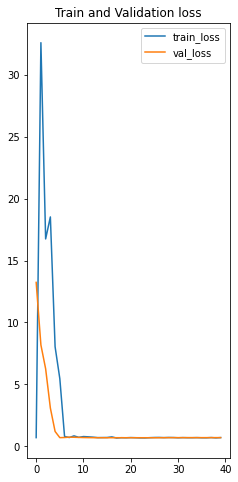

In [ ]:
import sys

app = QtWidgets.QApplication(sys.argv)
window = UI_Mainwindow()

app.exec_()